In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Embedding,Lambda,LSTM,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

2023-03-21 01:55:32.473150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 01:56:02.119990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 01:56:02.120072: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-21 01:56:13.084404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
def load_image(path):
    im = Image.open(path).convert('RGB')
    im = im.resize((256,256))
    im = np.array(im)
    im = im/256
    return im

def load_data(dir_path):
    image_list = []
    y_list = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            image_list.append(im)
        else:
            continue
    image_list = np.array(image_list)
    return image_list

In [6]:
x_path="./striped"
x=load_data(x_path)

In [5]:
y_path="./augmented"
y=load_data(y_path)


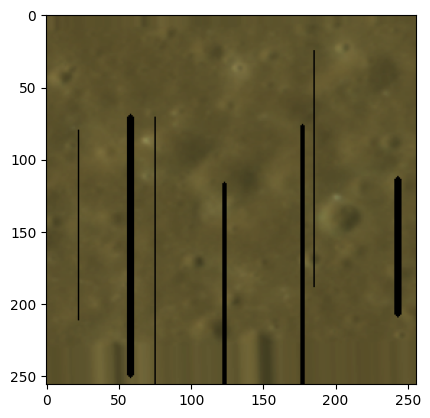

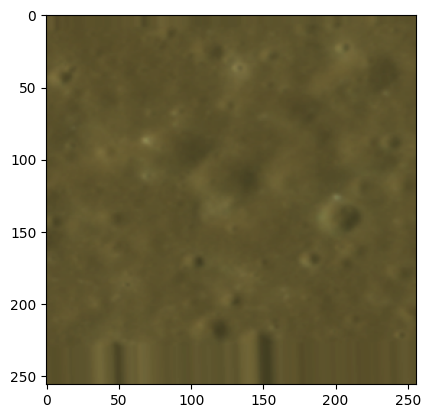

In [8]:
plt.imshow(x[0])
plt.show()
plt.imshow(y[0])
plt.show()

In [10]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=0)

In [14]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

In [15]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [22]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    inputs = Input(input_size)
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [23]:
unet = UNetCompiled(input_size=(256,256,3), n_filters=32, n_classes=3)

In [24]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_40[0][0]']              
                                )                                                           